<a href="https://colab.research.google.com/github/pooja614/ML_DL_projects/blob/main/Fraudulent_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Pooja KP

In [ ]:
!pip install --upgrade vaex

### Import Libraries and Load the Data

Import major libraries

In [6]:
import vaex 
import sys 
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.model_selection import train_test_split , KFold
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report                              
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
from IPython import display
from sklearn import preprocessing   
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn. preprocessing import StandardScaler
import pickle 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
import scipy.stats as stats 
from scipy.special import boxcox1p


dtypes={
    'step':'int32',
    'type':'category',
    'amount':'float32',
    'oldbalanceOrg':'float32',
    'newbalanceOrig':'float32',
    'oldbalanceDest':'float32',
    'newbalanceDest':'float32',
    'isFraud':'int32',
    'isFlaggedFraud':'int32',
} 

"""
After loading and observing the data, data types are converted
to types with lesser space while loading. 

""" 

folder_path = '/content/drive/MyDrive/ETE_projects/Fraud_Transactions/' 
df = pd.read_csv(folder_path + 'Fraud.csv', dtype=dtypes)

### Visualizing The Data

As there are common steps in visualizing the data, we apply them through function. 

In [4]:
def visualization():
    print(df.head()) 
    print('------------------------------------------------------------')
    print(df.shape)
    print('------------------------------------------------------------')
    print(df.info())         
    print('------------------------------------------------------------')
    print(df.type.value_counts())
    print('------------------------------------------------------------')
    print(df.iloc[0])
    print('------------------------------------------------------------')

visualization()

   step      type        amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.639648  C1231006815       170136.0   160296.359375   
1     1   PAYMENT   1864.280029  C1666544295        21249.0    19384.720703   
2     1  TRANSFER    181.000000  C1305486145          181.0        0.000000   
3     1  CASH_OUT    181.000000   C840083671          181.0        0.000000   
4     1   PAYMENT  11668.139648  C2048537720        41554.0    29885.859375   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
------------------------------------------------------------
(6362620, 11)
------

### Data Dictionary
About the columns:
<pre>
step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
amount - amount of the transaction in local currency.
nameOrig - customer who started the transaction
oldbalanceOrg - initial balance before the transaction
newbalanceOrig - new balance after the transaction
nameDest - customer who is the recipient of the transaction
oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.m
</pre>

In [26]:
df.head(3)

,step,type,nameOrig,nameDest,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest
0,1,PAYMENT,C1231006815,M1979787155,0,0,12.044359,11.984786,15.078545,0.0,0.0
1,1,PAYMENT,C1666544295,M2044282225,0,0,9.964112,9.872293,11.236083,0.0,0.0
2,1,TRANSFER,C1305486145,C553264065,1,0,5.204007,0.000000,6.827017,0.0,0.0


### 1. Data cleaning including missing values, outliers and multi-collinearity. 

In [100]:
df.isnull().sum() 

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

* There is no null values.  

#### Find types of transactions and number of unique transactions

In [11]:
 df['type'].unique() 

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [99]:
df['type'].value_counts()  

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

### Outliers Multi-Collinearity

* Correlation: correlation is applied on the dataframe. 
* Two variables are considered to be perfectly collinear if their correlation coefficient is +/- 1.0.

In [59]:
df.corr() 

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


* Most of the datapoints are not correlated. 
* Oldbalance is correlated with new_balance of person who intitiated transaction. 
* newbalanceDest and oldbalanceDest is correlated. 
* It is obivous to correlate as substraction and addition of the amount happens and thus these coluns are correlated.  
Thus I don't delete any of the columns as there is no explicit correlation between unrelated variables.  

### Skewness of the Data.


In [63]:
df.skew() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


step                0.375177
amount             30.993954
oldbalanceOrg       5.249137
newbalanceOrig      5.176885
oldbalanceDest     19.921761
newbalanceDest     19.352304
isFraud            27.779538
isFlaggedFraud    630.603629
dtype: float64


- We observe that data is largely positively skewed and does not have normal distribution. 
- After some exploration of feature engineering techniques
  <a href = "https://www.kaggle.com/code/prashant111/a-reference-guide-to-feature-engineering-methods/notebook">here</a> and methods to deal with <a href = 
  "https://rcompanion.org/handbook/I_12.html#:~:text=For%20right%2Dskewed%20data%E2%80%94tail,log%20(constant%20%E2%80%93%20x)">skewed data</a> log and boxcox transformation is employed. 
- For right-skewed data—tail is on the right, positive skew—, common transformations include square root, cube root, and log.



### Variable Transformation


- Apply log and boxcox transformation and choose relevant transformations for the respective columns. 
- 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest' are chosen as it has large skewness. 
- 0-1 values columns are note choosen.  




In [7]:
# apply logtransformation
skew_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df_logs = df[skew_cols]
df_boxcox = df[skew_cols]
for i in skew_cols: 
  df_logs.loc[:,i] = np.log(df_logs[i]+1)
  df_boxcox.loc[:,i] = boxcox1p(df_boxcox[i], 0.1) 


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [50]:
df_logs.skew()

amount           -0.555018
oldbalanceOrg    -0.259723
newbalanceOrig    0.440148
oldbalanceDest   -0.213261
newbalanceDest   -0.386937
dtype: float32

In [51]:
df_boxcox.skew()

amount           -0.076000
oldbalanceOrg     0.342407
newbalanceOrig    0.741744
oldbalanceDest   -0.040291
newbalanceDest   -0.201477
dtype: float32

After observing the skewness after transformation, 
* Choose boxcox transformation for amount, oldbalanceDest, newbalanceDest
* Choose log transformation for oldbalanceOrg, newbalanceOrg

In [8]:
df = pd.concat([df[['step','type','nameOrig', 'nameDest','isFraud', 'isFlaggedFraud']],df_logs[['oldbalanceOrg','newbalanceOrig']], df_boxcox[['amount', 'oldbalanceDest','newbalanceDest']]], axis=1, join='inner') 

In [10]:
print(df.shape)
df.head()

(6362620, 11)


,step,type,nameOrig,nameDest,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest
0,1,PAYMENT,C1231006815,M1979787155,0,0,12.044359,11.984786,15.078545,0.000000,0.0
1,1,PAYMENT,C1666544295,M2044282225,0,0,9.964112,9.872293,11.236083,0.000000,0.0
2,1,TRANSFER,C1305486145,C553264065,1,0,5.204007,0.000000,6.827017,0.000000,0.0
3,1,CASH_OUT,C840083671,C38997010,1,0,5.204007,0.000000,6.827017,17.076887,0.0
4,1,PAYMENT,C2048537720,M1230701703,0,0,10.634773,10.305174,15.509614,0.000000,0.0


- Thus is the transformed data

### One-hot Encoding

- Visualize the data for fraud transactions. 

In [25]:
df[df.isFraud == 1].tail(30) 

,step,type,nameOrig,nameDest,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest
6362590,741,TRANSFER,C509686434,C1310143791,1,0,12.687657,0.0,25.564604,0.000000,0.000000
6362591,741,CASH_OUT,C919525792,C993635374,1,0,12.687657,0.0,25.564604,27.579817,29.329456
6362592,741,TRANSFER,C457476945,C1688658215,1,0,12.857517,0.0,26.173862,0.000000,0.000000
6362593,741,CASH_OUT,C369315575,C2069429837,1,0,12.857517,0.0,26.173862,32.192913,33.021099
6362594,741,TRANSFER,C31496887,C1251365829,1,0,11.884119,0.0,22.818651,0.000000,0.000000
6362595,741,CASH_OUT,C1092829426,C716019997,1,0,11.884119,0.0,22.818651,0.000000,22.818651
6362596,741,TRANSFER,C1112979339,C2114078084,1,0,10.788161,0.0,19.411955,0.000000,0.000000
6362597,741,CASH_OUT,C1706094385,C2109905271,1,0,10.788161,0.0,19.411955,27.245598,27.582729
6362598,742,TRANSFER,C1044665079,C750074708,1,0,15.204067,0.0,35.740852,0.000000,0.000000
6362599,742,CASH_OUT,C1970706589,C637394241,1,0,15.204067,0.0,35.740852,30.642662,36.981121


- Thus we observe that customer-to customer transactions has more frauds than other relationship.  
- We need to modify the columns  to preserve the information.
### Preserving customer or merchant information. 
- Regex is applied to rename customer id as 'C' and merchant as 'M'

In [11]:
import re  
df['nameOrig'] = df['nameOrig'].apply(lambda x: re.sub('C[A-Za-z0-9]*', 'C',x)) 
df['nameDest'] = df['nameDest'].apply(lambda x: re.sub('C[A-Za-z0-9]*','C',x))   
df['nameDest'] = df['nameDest'].apply(lambda x: re.sub('M[A-Za-z0-9]*','M',x)) 
## one hot the keys. 
df.head() 

,step,type,nameOrig,nameDest,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest
0,1,PAYMENT,C,M,0,0,12.044359,11.984786,15.078545,0.000000,0.0
1,1,PAYMENT,C,M,0,0,9.964112,9.872293,11.236083,0.000000,0.0
2,1,TRANSFER,C,C,1,0,5.204007,0.000000,6.827017,0.000000,0.0
3,1,CASH_OUT,C,C,1,0,5.204007,0.000000,6.827017,17.076887,0.0
4,1,PAYMENT,C,M,0,0,10.634773,10.305174,15.509614,0.000000,0.0


In [31]:
df.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

* Cash in: to exchange money for some insurance policy
* Cash Out: To convert non-cash asset into Cash


In [32]:
df[df.isFraud == 1].type.value_counts() 

CASH_OUT    4116
TRANSFER    4097
CASH_IN        0
DEBIT          0
PAYMENT        0
Name: type, dtype: int64

* It is observed that cash-out and transfer modes have more fraud chances.


- Onehot encoding is applied to 'nameOrig' and 'nameDest' which contains 'C' and 'M' values. 'type' is also encoded


In [12]:
from sklearn import preprocessing 
ohe = preprocessing.OneHotEncoder()                                       
df= pd.get_dummies(df, columns=['type','nameOrig', 'nameDest'])
df.head(3)

,step,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,nameOrig_C,nameDest_C,nameDest_M
0,1,0,0,12.044359,11.984786,15.078545,0.0,0.0,0,0,0,1,0,1,0,1
1,1,0,0,9.964112,9.872293,11.236083,0.0,0.0,0,0,0,1,0,1,0,1
2,1,1,0,5.204007,0.000000,6.827017,0.0,0.0,0,0,0,0,1,1,1,0


In [55]:
print(len(df.columns))
df.columns

16


Index(['step', 'isFraud', 'isFlaggedFraud', 'oldbalanceOrg', 'newbalanceOrig',
       'amount', 'oldbalanceDest', 'newbalanceDest', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
       'nameOrig_C', 'nameDest_C', 'nameDest_M'],
      dtype='object')

In [56]:
# Save preprocessed dataset
df.to_csv(folder_path+ 'preprocessed.csv')

## Modelling

* Train test split and explore the division 

In [13]:
features = ['step', 'isFlaggedFraud', 'oldbalanceOrg', 'newbalanceOrig',
       'amount', 'oldbalanceDest', 'newbalanceDest', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
       'nameOrig_C', 'nameDest_C', 'nameDest_M']  
target=['isFraud'] 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(df[features],df['isFraud'], test_size=0.2, random_state=42) 

In [16]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5090096 entries, 6271196 to 1692743
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int32  
 1   isFlaggedFraud  int32  
 2   oldbalanceOrg   float32
 3   newbalanceOrig  float32
 4   amount          float32
 5   oldbalanceDest  float32
 6   newbalanceDest  float32
 7   type_CASH_IN    uint8  
 8   type_CASH_OUT   uint8  
 9   type_DEBIT      uint8  
 10  type_PAYMENT    uint8  
 11  type_TRANSFER   uint8  
 12  nameOrig_C      uint8  
 13  nameDest_C      uint8  
 14  nameDest_M      uint8  
dtypes: float32(5), int32(2), uint8(8)
memory usage: 213.6 MB


In [18]:
y_train

6271196    0
1888243    0
5549957    0
2025342    0
682342     0
          ..
1570006    0
2234489    0
4926484    0
4304572    0
1692743    0
Name: isFraud, Length: 5090096, dtype: int32

In [76]:
len(x_train), len(x_test)

(5090096, 1272524)

In [83]:
y_test.value_counts() 

0    1270904
1       1620
Name: isFraud, dtype: int64

* We observe the class distribution in y_train and y_test, training and test set has imbalanced classes. 
* Imbalance in training set will result in poor model. 
* Thus sampling of training set is employed. 

### Sampling 

* SMOTE is used to oversample the minority class-here 'Fraud'(1) class
* Minority class is sampled with 0.025 times the majority class 
* Not-Fraud class (0) is undersampled to double teh number of 'Fraud' class

In [19]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from collections import Counter 
over = SMOTE(sampling_strategy=0.025) 
under=RandomUnderSampler(random_state=42, sampling_strategy=0.5)
steps = [('o', over),('u', under)] 
pipeline = Pipeline(steps=steps) 
x_res, y_res = pipeline.fit_resample(x_train[features], y_train) 
print(Counter(y_res)) 

Counter({0: 254174, 1: 127087})


### Fit the Model 

* RandomForestClassifier and Logistic Regression is chosen for modelling. 
* Hyperparameters are chosen after experimention and prior experience. 
* Model is saved. 

In [64]:
from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier(criterion = 'gini',
                              max_depth = 48,
                              max_features = 'sqrt',
                              n_estimators = 300)
                             

clf.fit(x_res, y_res) 

RandomForestClassifier(max_depth=48, max_features='sqrt', n_estimators=300)

In [69]:
import joblib
f_name = folder_path + 'rf_model.sav'
joblib.dump(clf, f_name)

['/content/drive/MyDrive/ETE_projects/Fraud_Transactions/rf_model.sav']

In [65]:
score = clf.score(x_test,y_test)
y_preds = clf.predict(x_test)
score, y_preds 

(0.9962185389037849, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))

* 99.6% accuracy is obtained on test data.  

## Visualizing Results 

### Confusion Matrix

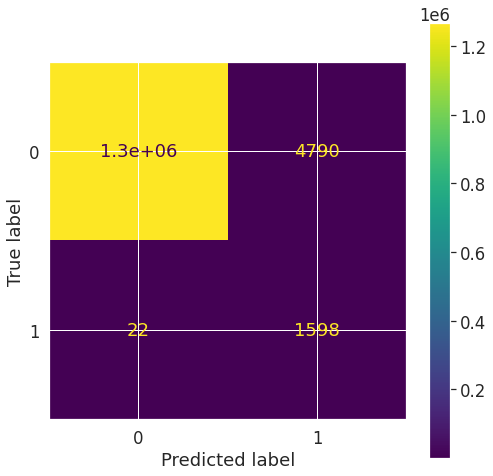

In [67]:
fig, ax = plt.subplots(figsize = (8,8))
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true = y_test,
                                        y_pred = y_preds, ax=ax);

* We observe that 22 'Fraud' classes has been miss predicted as non-Fraud. 

### Classification Report

In [80]:
c_r = (classification_report(y_test, y_preds, digits=4))
print(c_r)

              precision    recall  f1-score   support

           0     1.0000    0.9962    0.9981   1270904
           1     0.2502    0.9864    0.3991      1620

    accuracy                         0.9962   1272524
   macro avg     0.6251    0.9913    0.6986   1272524
weighted avg     0.9990    0.9962    0.9973   1272524



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


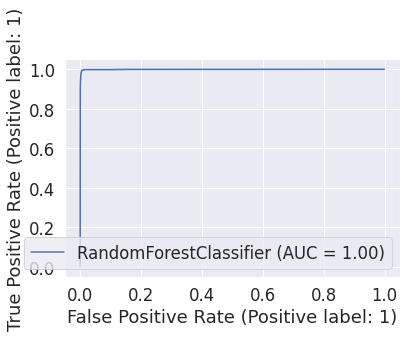

In [69]:
from sklearn.metrics import plot_roc_curve 
plot_roc_curve(clf, x_test, y_test) 

### Logistic Regression

In [49]:
clf_lg = LogisticRegression(C=0.20433597178569418, 
                         solver = "liblinear")
clf_lg.fit(x_train, y_train);

In [50]:
score_lg = clf_lg.score(x_test, y_test)
y_preds_lg = clf_lg.predict(x_test)
score_lg, y_preds_lg  

(0.9993218202564352, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))

In [92]:
import pickle
file_n = folder_path + 'lg_model.sav' 
pickle.dump(clf, open(file_n, 'wb'))        

* Logistic Regression Model has achieved ever higher accuracy of 99.9%

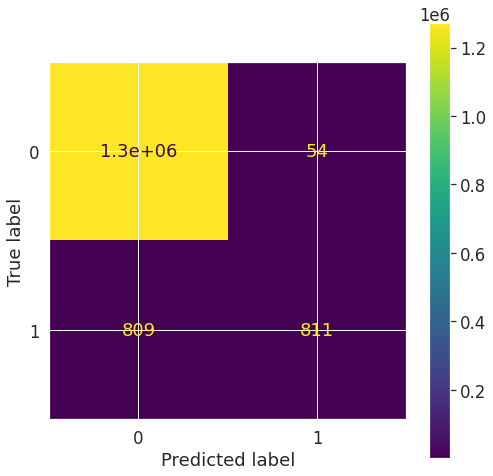

In [59]:
fig, ax = plt.subplots(figsize = (8,8))
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true = y_test,
                                        y_pred = y_preds_lg, ax=ax);

In [81]:
c_r = (classification_report(y_test, y_preds_lg, digits=4))
print(c_r)

              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997   1270904
           1     0.9376    0.5006    0.6527      1620

    accuracy                         0.9993   1272524
   macro avg     0.9685    0.7503    0.8262   1272524
weighted avg     0.9993    0.9993    0.9992   1272524



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


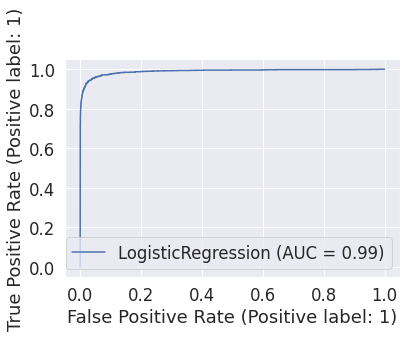

In [63]:
from sklearn.metrics import plot_roc_curve 
plot_roc_curve(clf_lg, x_test, y_test) 

* Even though logistic Regression has given higher accuracy, RandomForestClassifier is more  reliable.
* As false negatives is lesser in RandomForest, ie, 'Fraud' detected as 'non-Fraud' is very less. 

## Feature Importance

* Logistic regression algorithm which is based on independent variables and coefficient attached to it, thus has measure of features that has played important role. 

In [66]:
# check cefficients
clf_lg.coef_

array([[ 4.65628901e-03,  8.69872600e-01,  2.62287600e+00,
        -7.22176889e-01, -2.83165406e-01,  3.59154911e-03,
        -1.81465469e-01, -6.35228255e+00,  8.00453306e-01,
        -3.22746989e-01, -5.39313466e+00,  9.45924399e-01,
        -1.03217865e+01, -4.92865184e+00, -5.39313466e+00]])

In [30]:
len(x_train.columns)

15

In [74]:
# get importance
importance = clf_lg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00466
Feature: 1, Score: 0.86987
Feature: 2, Score: 2.62288
Feature: 3, Score: -0.72218
Feature: 4, Score: -0.28317
Feature: 5, Score: 0.00359
Feature: 6, Score: -0.18147
Feature: 7, Score: -6.35228
Feature: 8, Score: 0.80045
Feature: 9, Score: -0.32275
Feature: 10, Score: -5.39313
Feature: 11, Score: 0.94592
Feature: 12, Score: -10.32179
Feature: 13, Score: -4.92865
Feature: 14, Score: -5.39313


In [76]:
# match for labels
feature_dict = dict(zip(x_train.columns, list(clf_lg.coef_[0])))
feature_dict 

{'step': 0.004656289013724419,
 'isFlaggedFraud': 0.8698726000742544,
 'oldbalanceOrg': 2.6228760037515784,
 'newbalanceOrig': -0.7221768889810366,
 'amount': -0.2831654057222859,
 'oldbalanceDest': 0.003591549111341628,
 'newbalanceDest': -0.18146546918754736,
 'type_CASH_IN': -6.352282554466994,
 'type_CASH_OUT': 0.8004533064584293,
 'type_DEBIT': -0.3227469888181435,
 'type_PAYMENT': -5.393134658368212,
 'type_TRANSFER': 0.9459243991976514,
 'nameOrig_C': -10.32178649561862,
 'nameDest_C': -4.928651837304061,
 'nameDest_M': -5.393134658368212}

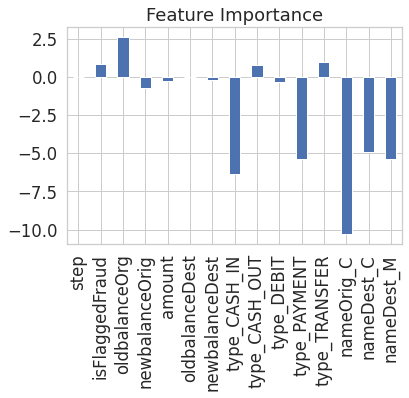

In [79]:
sns.set_style('whitegrid')
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False);

* This is a classification problem with classes 0 and 1. 
* The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.
* 'isFlaggedFraud', 'oldbalanceOrg', 'type_CASH_OUT', 'type_TRANSFER' are fraud causing/predicting features. 
* This 'isFlaggedFraud' column that marks illegal attempts based on the specified condition of software has played
important role and addon to fraud transaction
* 'Cash-Out' and 'Transfer' mode have found to be modes through which fraud takes place. 


### Answering the Questions 
<pre>

1. Data cleaning including missing values, outliers and multi-collinearity.
   - There are no null values. Thus not much of data cleaning is involved. 
   - Outliers are not removed for preserving loss of data based on transaction  and tree based algorithms are robust in handling outliers. 
   - Correlation is checked with following observation:
      - Most of the datapoints are not correlated.
      - Oldbalance is correlated with new_balance of person who intitiated transaction.
      - newbalanceDest and oldbalanceDest is correlated.
      - It is obivous to correlate as substraction and addition of the amount happens and thus these coluns are correlated.
      - Thus I don't delete any of the columns as there is no explicit correlation between unrelated variables. 
  
2. Describe your fraud detection model in elaboration. 

   Fraud Detection Model contains following steps:
   -Import and Explore Dataset
   -Remove correlation if there is correlation between unrelated features. 
   -Apply Variable Transformation on the skewed columns. 
   -Apply onehot encoding on categorical variables
   -Preserve customer and merchant id information to form additional categorical features. 
   -Train test split with 80-20 rule. 
   -Apply sampling for class imbalance. 
   -Fit the model to RandomForestClassifier and Logistic Regression. 
   -Visualize and analyse the results. 

3. How did you select variables to be included in the model?
   Variables are selected based on following criteria:
   -Relevance of the variables. 
   -Non-collinearity and no significant correlation to prevent model from being sensitive. 
   -Corecting the skewness.  
   -Creating additional features if required.
   -Normalized data (here transformation have played this role)

4. Demonstrate the performance of the model by using best set of tools. 
   
   Accuracy: 
   -Accuracy is used for measuring accuracy. 
   -Only accuracy cannot be relied as in Fraud detection problem, recall and precision is more important than other metrics. 
   Classification report:
   -It gives complete picture of precision-recall and f1-score. 
   -RandomForestClassifier gives more recall rate and less precision where as logistic Regression is vice-versa. 
   -Recall is important in this problem as we want our model to spot as many real 1 as possible. 
   -Thus RandomForest is the best performing model.  
   Confusion Matrix:
   -This metric gives best view and understanding regarding the prediction done by the model. 
   -RandomForestClassifier has given less number of False  Negative -22 where as logistic regression has given 809 False Negatives. Thus RF is more reliable. 
   ROC curve:
   - ROC Curve is plotted to visualize true-positive rate and true negative rate. 

5. What are the key factors that predict fraudulent customer? 
   'isFlaggedFraud', 'oldbalanceOrg', 'type_CASH_OUT', 'type_TRANSFER' are fraud causing/predicting features.

6. Do these factors make sense? If yes, How? If not, How not? 
   Yes, these factors absolutely makes sense. 
   <b>isFlaggedFraud</b> 
   -column that marks illegal attempts based on the specified condition of software has played important role and addon to fraud detection. Thus the existing software that classifies the attempts based on upper limit of amount as criteria is important precautionary flag. 
   <b>oldbalanceOrg</b>
   - This clearly indicates that customer/individual with more balance in his account is prone to fraud transaction. 
   - Indirectly we can also infer that account/individuals with more cash is pre-tracked by fraudsters both online and offline. 
   <b>Cash-Out</b>
   - Cashout refers to convert non-cash asset into Cash. Thus online selling of large goods etc is more prone to frauds. 
   <b>Transfer</b>
   - Uninformed/half informed transfers mode have found to be modes through which fraud takes place. 

7. What kind of prevention should be adopted while company update its infrastructure? 
  - Can implement multiple account/distributed for account with huge balance.
  - Sperate account for online transactions. 
  - Special mode for cash out transactions. 
  - Special regestering of account users for transfer modes. 
8. Assuming these actions have been implemented, how would you determine if they work? 
  - Data of implemented software must be collected and must analyze the results. 
</pre>

     

